## canny edge dector

The Canny edge detection algorithm is composed of 5 steps:
Noise reduction;
Gradient calculation;
Non-maximum suppression;
Double threshold;
Edge Tracking by Hysteresis.

In [18]:
%matplotlib inline

import numpy as np
from scipy.ndimage.filters import convolve
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import cv2
from scipy import ndimage
import scipy

#### 1. Noise Reduction; reduce noise by applying Gaussian blur to smooth it.(an image convolution technique using a Guassian filter)

In [2]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 /(2.0 * np.pi * sigma **2)
    g = np.exp(-((x**2 + y**2)/ (2.0 * sigma**2))) * normal
    return g

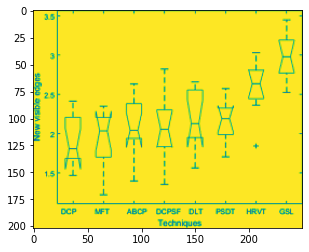

In [68]:
image = mpimg.imread('images/dehazing.png')
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_img)

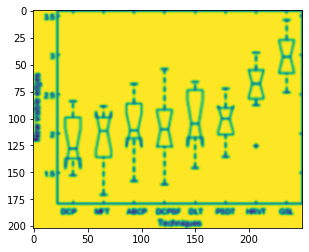

In [69]:
result_img = convolve(gray_img, gaussian_kernel(5))
plt.imshow(result_img)

### Gradient calculation: The Gradient calculation step detects the edge intensity and direction by calculating the gradient of the image using edge detection operators.

Edges correspond to a change of pixels’ intensity. To detect it, the easiest way is to apply filters that highlight this intensity change in both directions: horizontal (x) and vertical (y)


When the image is smoothed, the derivatives Ix and Iy w.r.t. x and y are calculated. It can be implemented by convolving I with Sobel kernels Kx and Ky, respectively:

In [70]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G *= 255.0/np.max(G)    
    theta = np.arctan2(Iy, Ix)
    
    #plt.imshow(G, cmap=plt.cm.gray)
    
    return (G, theta)

In [71]:
G, theta = sobel_filters(result_img)

### Non-maximum suppression

The principle is simple: the algorithm goes through all the points on the gradient intensity matrix and finds the pixels with the maximum value in the edge directions.

In [72]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

In [73]:
result = non_max_suppression(G, theta)

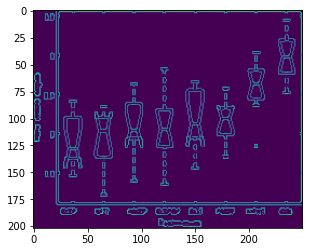

In [74]:
plt.imshow(result)

### Double threshold

The double threshold step aims at identifying 3 kinds of pixels: strong, weak, and non-relevant:

Strong pixels are pixels that have an intensity so high that we are sure they contribute to the final edge.

Weak pixels are pixels that have an intensity value that is not enough to be considered as strong ones, but yet not small enough to be considered as non-relevant for the edge detection.
Other pixels are considered as non-relevant for the edge.

In [75]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return res

In [76]:
thresh_image = threshold(result)

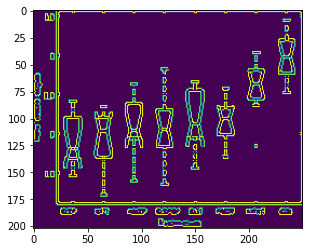

In [77]:
plt.imshow(thresh_image)

### Edge Tracking by Hysteresis

Based on the threshold results, the hysteresis consists of transforming weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one, as described below:

In [78]:
def hysteresis(img, weak=75, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

In [79]:
final_img = hysteresis(thresh_image)

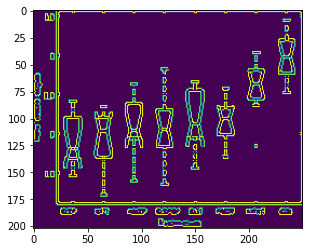

In [80]:
plt.imshow(final_img)

https://medium.com/@iKhushPatel/convert-video-to-images-images-to-video-using-opencv-python-db27a128a481
    